<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/2b_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Red neural convolucional

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar un perceptrón multicapa para la tarea de clasificación de imágenes. Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Tiene imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.



## 1 Carga de datos

Comenzaremos descargando y leyendo el conjunto de datos. Aprovecharemos que Tensorflow cuenta con utilerias en el paquete [`tf.keras.datasets`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/datasets) para descargar conjuntos de datos de referencia preprocesados.

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras import Model

tf.random.set_seed(2019)

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Una vez descargadas las imágenes, podemos visualizar algunas para ver cómo lucen.

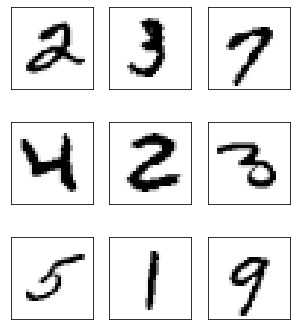

In [2]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[5 * i], cmap='Greys')

Ahora normalizamos las imágenes.

In [3]:
x_train, x_test = tf.cast(x_train, tf.float32) / 255.0, tf.cast(x_test, tf.float32) / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
y_train = y_train[..., tf.newaxis]
y_test = y_test[..., tf.newaxis]

Definimos nuestra tubería de datos para el conjunto de entrenamiento.

In [4]:
batch_size = 64
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds = ds.shuffle(60000)
ds = ds.batch(batch_size)

for x, y_true in ds:
    print('x={} x.shape={}'.format(x.numpy().flatten(), x.shape))
    print('y={} y_true.shape={}'.format(y_true.numpy().flatten(), y_true.shape))
    break

W0904 19:46:06.657560 140656526202688 deprecation.py:323] From /home/bere/.virtualenvs/cap/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x=[0. 0. 0. ... 0. 0. 0.] x.shape=(64, 28, 28, 1)
y=[2 6 0 7 8 7 5 7 7 4 4 4 3 2 3 7 7 6 3 7 0 3 1 3 1 6 1 3 1 0 6 4 9 9 4 0 5
 9 8 8 0 9 2 1 6 1 3 0 7 6 7 0 1 8 7 7 1 7 3 7 9 7 0 3] y_true.shape=(64, 1)


## 2 Definición del modelo

In [5]:
class CNN(Model):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = Conv2D(4, 3, padding='same')
    self.pool1 = MaxPooling2D(pool_size=2, padding='same')
    self.conv2 = Conv2D(8, 3, padding='same')
    self.pool2 = MaxPooling2D(pool_size=2, padding='same')
    self.flat = Flatten()
    self.fc = Dense(10)

  def call(self, x):
    #####################
    # (N, 28, 28, 1) =>
    # (N, 28, 28, 4)
    x = self.conv1(x)
    # (N, 28, 28, 4)
    x = tf.nn.relu(x)
    # (N, 28, 28, 4) =>
    # (N, 14, 14, 4)
    x = self.pool1(x)
    #####################
    # (N, 14, 14, 4) =>
    # (N, 14, 14, 8)
    x = self.conv2(x)
    # (N, 14, 14, 8)
    x = tf.nn.relu(x)
    # (N, 14, 14, 8) =>
    # (N, 7, 7, 8)
    x = self.pool2(x)
    #####################
    # (N, 7, 7, 8) =>
    # (N, 7*7*8)
    x = self.flat(x)
    #####################
    # (N, 7*7*8) =>
    # (N, 10)
    x = self.fc(x)
    # (N, 10)
    x = tf.nn.softmax(x)
    return x

In [6]:
model = CNN()
model.build(input_shape=(None, 28, 28 , 1))
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3930      
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
_____________________________________________________________

### Quiz 1

¿Comó sacamos las cuentitas del número de parámeros de las capas?

### Definición de pérdida y optimizador

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

### Definición de métricas

Las clases dentro de `tf.keras.metrics` están diseñadas para mantener un histórico de una métrica a lo largo de los pasas de entrenamiento y agregarlo (con el promedio por ejemplo) para obtener el desempeño de la métrica a nivel epoca.

In [8]:
# historiales a nivel época
loss_epoch = tf.keras.metrics.SparseCategoricalCrossentropy()
acc_epoch = tf.keras.metrics.SparseCategoricalAccuracy()

## 3 Entrenamiento

In [9]:
##########################################################
# se crea una marca de tiempo
model_name = datetime.now().strftime('%y%m%d-%H%M%S')
# se crea una ruta para almacenar las métricas
train_dir = 'logs/{}/train'.format(model_name)
# se crea un escritor
train_writer = tf.summary.create_file_writer(train_dir)
print("Trainig model {}".format(model_name))

##########################################################
# decorador para producir la gráfica de cómputo estática
@tf.function
def train_step(x, y_true, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_fn(y_true, y_pred)            
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return y_pred

##########################################################

# visualización de la gráfica en tensorboard
# habilitamos el rastreo del flujo de cómputo para tensorboard
tf.summary.trace_on()
# se ejecuta el modelo
train_step(x_train[0:1], y_train[0:1], model, loss_fn, optimizer) 
# activo el contexto del escritor
with train_writer.as_default():
    # exporto la gráfica
    tf.summary.trace_export(model_name, 0)

##########################################################

epochs = 15

for epoch in range(epochs):

    for x, y_true in ds:
        y_pred = train_step(x, y_true, model, loss_fn, optimizer)
            
        loss_epoch(y_true, y_pred)
        acc_epoch(y_true, y_pred)

    loss_val = loss_epoch.result().numpy() * 100
    acc_val = acc_epoch.result().numpy() * 100
    loss_epoch.reset_states()
    acc_epoch.reset_states()
    
    # escribimos las métricas
    with train_writer.as_default():
        tf.summary.scalar('loss', loss_val, epoch)
        tf.summary.scalar('acc', acc_val, epoch)

    print('E{:2d} loss={:6.2f}, acc={:6.2f}'.format(epoch, loss_val, acc_val))

Trainig model 190904-194607
E 0 loss=228.41, acc= 10.51
E 1 loss=214.20, acc= 28.54
E 2 loss=157.14, acc= 60.21
E 3 loss= 80.52, acc= 77.61
E 4 loss= 55.11, acc= 83.66
E 5 loss= 45.92, acc= 86.25
E 6 loss= 41.06, acc= 87.59
E 7 loss= 37.87, acc= 88.59
E 8 loss= 35.52, acc= 89.34
E 9 loss= 33.65, acc= 89.91
E10 loss= 32.10, acc= 90.41
E11 loss= 30.76, acc= 90.83
E12 loss= 29.58, acc= 91.23
E13 loss= 28.52, acc= 91.55
E14 loss= 27.56, acc= 91.88


## 4 Validación

In [12]:
y_pred_test = model(x_test)
print(acc_epoch(y_test, y_pred_test).numpy() * 100)

92.46000051498413


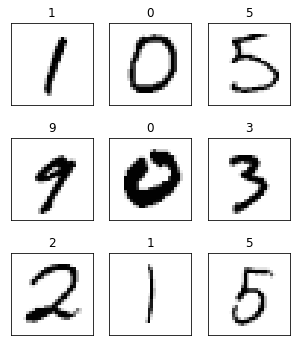

In [13]:
x_test = tf.squeeze(x_test)
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[5 * i], cmap='Greys')
    plt.title(y_pred_test[5*i].numpy().argmax())